In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile

from skimage.io import imread   # Import imread from skimage

import os
from tqdm import tqdm
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import regularizers

from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Prepare data

In [ ]:
# скачиваем тренировочный датасет
!gdown --id 1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TG9P5B2k3eTbC4XDxDmEc07dyAORPC16
To: /content/train.zip
100% 2.28G/2.28G [00:41<00:00, 55.2MB/s]


In [ ]:
def extract_images(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        total_files = len(zip_ref.namelist())
        with tqdm(total=total_files, desc="Разархивация") as pbar:
            for file in zip_ref.namelist():
                zip_ref.extract(file, extract_path)
                pbar.update(1)

    print("Архив успешно разархивирован.")

In [ ]:
# Указываем путь к архиву
zip_path = '/content/train.zip'
extract_path = '/content/drive/MyDrive/skillbox-computer-vision-project'

extract_images(zip_path, extract_path)

Разархивация: 100%|██████████| 50057/50057 [11:05<00:00, 75.19it/s]

Архив успешно разархивирован.


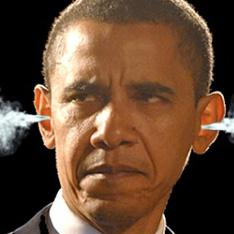

In [ ]:
Image.open('/content/drive/MyDrive/skillbox-computer-vision-project/train/anger/100.jpg')

In [ ]:
# Путь к исходной папке с изображениями
source_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/train/'

# # Пути к папкам, в которые будут сохранены измененные изображения
# resized_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/resized_train/'
# grayscaled_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/grayscaled_train/'

# Пути к папкам, в которые будут сохранены измененные изображения
resized_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/resized_train_48/'
grayscaled_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/grayscaled_train_48/'

In [ ]:
def preprocess_images(source_folder, resized_folder):
    # Создание новой папки, если она не существует
    if not os.path.exists(resized_folder):
        os.makedirs(resized_folder)

    # Проход по каждому изображению в исходной папке
    for emotion in os.listdir(source_folder):
        emotion_folder = os.path.join(source_folder, emotion)
        with tqdm(total=len(os.listdir(emotion_folder)),
                  desc=f"Обработка изображений в папке {emotion}") as pbar:
            for image_name in os.listdir(emotion_folder):
                image_path = os.path.join(emotion_folder, image_name)

                # Открытие изображения
                image = Image.open(image_path)

                # Изменение размера до nxn пикселей
                resized_image = image.resize((48, 48))

                # Проверка существования папки для текущей эмоции
                emotion_resized_folder = os.path.join(resized_folder, emotion)
                if not os.path.exists(emotion_resized_folder):
                    os.makedirs(emotion_resized_folder)

                # Сохранение измененного изображения в новой папке
                resized_image.save(os.path.join(emotion_resized_folder, image_name))
                pbar.update(1)

In [ ]:
# Выполнение предобработки изображений
preprocess_images(source_folder, resized_folder)

Обработка изображений в папке uncertain: 100%|██████████| 3567/3567 [05:15<00:00, 11.29it/s]


In [ ]:
def convert_images_to_grayscale(resized_folder, grayscaled_folder):
    # Конвертирование изображений из папки resized_folder в оттенки серого
    for emotion_folder in os.listdir(resized_folder):
        emotion_path = os.path.join(resized_folder, emotion_folder)
        grayscaled_emotion_folder = os.path.join(grayscaled_folder, emotion_folder)
        if not os.path.exists(grayscaled_emotion_folder):
            os.makedirs(grayscaled_emotion_folder)
        with tqdm(total=len(os.listdir(emotion_path)), desc=f"Converting images in {emotion_folder}") as pbar:
            for image_file in os.listdir(emotion_path):
                image_path = os.path.join(emotion_path, image_file)

                img = cv2.imread(image_path)

                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # новое имя файла для изображения в оттенках серого
                gray_image_path = os.path.join(grayscaled_emotion_folder, image_file)

                cv2.imwrite(gray_image_path, gray_img)
                pbar.update(1)

In [ ]:
# Выполнение обработки изображений
convert_images_to_grayscale(resized_folder, grayscaled_folder)

Converting images in uncertain: 100%|██████████| 3567/3567 [01:01<00:00, 58.32it/s]


In [ ]:
# Создание нового DataFrame
new_df = pd.DataFrame(columns=['image_path', 'emotion'])

# Проход по каждому изображению в новой папке
for emotion in os.listdir(grayscaled_folder):
    emotion_folder = os.path.join(grayscaled_folder, emotion)
    for image_name in os.listdir(emotion_folder):
        image_path = os.path.join(emotion_folder, image_name)

        # Получение метки класса из пути к изображению
        emotion_label = emotion

        # Добавление записи в новый DataFrame
        new_df = new_df.append({'image_path': image_path, 'emotion': emotion_label}, ignore_index=True)
# перетасовка строк
df = new_df.iloc[np.random.permutation(len(df))]
df.to_csv('/content/drive/MyDrive/skillbox-computer-vision-project/new_df.csv', index=False)

Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-5-d036913a8bfd>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df_224 = new_df_224.append({'image_path': image_path, 'emotion': emotion_label}, ignore_index=True)
<ipython-input-5-d036913a8bfd>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df_224 = new_df_224.append({'image_path': image_path, 'emotion': emotion_label}, ignore_index=True)
<ipython-input-5-d036913a8bfd>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df_224 = new_df_224.append({'image_path': image_path, 'emotion': emotion_label}, ignore_index=True)
<ipython-input-5-d036913a8bfd>:14: FutureWarning: The frame.append method is deprecated and will be removed fr

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/skillbox-computer-vision-project/new_df.csv')
unique_values = df['emotion'].unique()
print(unique_values)
df.head()

['contempt' 'uncertain' 'anger' 'surprise' 'fear' 'sad' 'happy' 'neutral'
 'disgust']


,image_path,emotion
0,/content/drive/MyDrive/skillbox-computer-visio...,contempt
1,/content/drive/MyDrive/skillbox-computer-visio...,uncertain
2,/content/drive/MyDrive/skillbox-computer-visio...,anger
3,/content/drive/MyDrive/skillbox-computer-visio...,surprise
4,/content/drive/MyDrive/skillbox-computer-visio...,fear


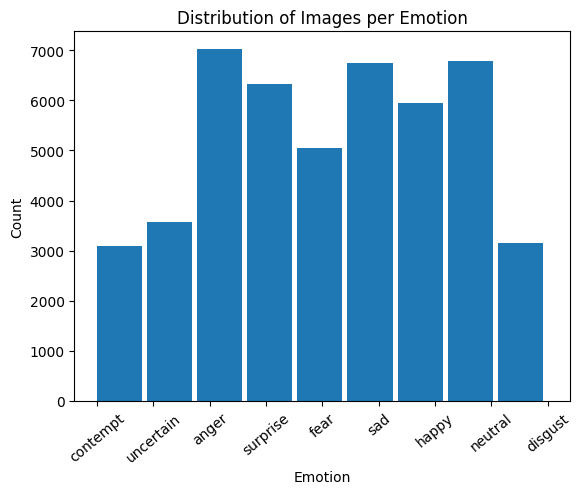

anger        7023
neutral      6795
sad          6740
surprise     6323
happy        5955
fear         5044
uncertain    3567
disgust      3155
contempt     3085
Name: emotion, dtype: int64

In [ ]:
# Построение гистограммы распределения эмоций
plt.hist(df['emotion'], bins=df['emotion'].nunique(), align='mid', width=0.8)
plt.xlabel('Emotion')
plt.xticks(rotation=40)
plt.ylabel('Count')
plt.title('Distribution of Images per Emotion')
plt.show()
df['emotion'].value_counts()

In [ ]:
# перетасовка строк
# df = df.iloc[np.random.permutation(len(df))]
# df.to_csv('/content/drive/MyDrive/skillbox-computer-vision-project/new_df.csv', index=False)

In [ ]:
# Создание пустого списка для хранения результатов
image_list = []

# Использование tqdm для отслеживания прогресса выполнения
for image_path in tqdm(df['image_path']):
    image = imread(image_path)
    image_list.append(image)

# Преобразование списка в массив NumPy
X = np.array(image_list)

# X = np.array(df['image_path'].apply(imread).to_list())

100%|██████████| 47687/47687 [3:23:05<00:00,  3.91it/s]


### Создание генераторов, моделей, обучение нейросети.

In [ ]:
# Сохранение переменной X в файл
# np.save('/content/drive/MyDrive/skillbox-computer-vision-project/X_48.npy', X)

# Загрузка переменной X из файла
X = np.load('/content/drive/MyDrive/skillbox-computer-vision-project/X_48.npy')

In [ ]:
from sklearn.utils import class_weight

from sklearn.utils.class_weight import compute_class_weight

# Преобразование столбца 'emotion' в числовые метки
label_map= {'anger':0,
            'contempt':1,
            'disgust':2,
            'fear':3,
            'happy':4,
            'neutral':5,
            'sad':6,
            'surprise':7,
            'uncertain':8}

# y = (df['emotion'].apply(lambda x: label_map[x])).values
labels = df['emotion'].apply(lambda x: label_map[x])
y = labels.values
unique, counts = np.unique(y, return_counts=True)
print("Распределение классов:", dict(zip(unique, counts)))

# Взвешивание классов
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(labels),
                                     y= labels)

# Разделение на тренировочную и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Взглянем на распределение весов классов после взвешивания классов и разделения на выборки
class_weights_dict = dict(enumerate(class_weights))

weighted_y_test = np.multiply(y_test, [class_weights_dict[i] for i in y_test])
# Вычисление распределениия весов классов после применения взвешивания классов для y_train
weighted_unique, weighted_counts = np.unique(weighted_y_test, return_counts=True)
print("Распределение весов классов после применения взвешивания классов для y_test:", dict(zip(weighted_unique, weighted_counts)))

weighted_y_train = np.multiply(y_train, [class_weights_dict[i] for i in y_train])
# Вычисление распределениия весов классов после применения взвешивания классов для y_test
weighted_unique, weighted_counts = np.unique(weighted_y_train, return_counts=True)
print("Распределение весов классов после применения взвешивания классов для y_train:", dict(zip(weighted_unique, weighted_counts)))

# one-hot encoding к меткам y_train и y_test с помощью функции to_categorical из Keras
y_train = to_categorical(y_train, num_classes = 9)
y_test = to_categorical(y_test, num_classes = 9)

# Приведение формы входных данных X_train и X_test в формат (количество образцов, высота, ширина, каналы)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print('Train: ', X_train.shape,'\n', 'Test: ', X_test.shape)

Распределение классов: {0: 7023, 1: 3085, 2: 3155, 3: 5044, 4: 5955, 5: 6795, 6: 6740, 7: 6323, 8: 3567}
Распределение весов классов после применения взвешивания классов для y_test: {0.0: 2074, 1.717522060147668: 945, 3.1514010044937883: 1533, 3.358830780066913: 938, 3.5590633454613303: 1764, 3.898863543455155: 2105, 4.716815034619189: 1958, 5.865868873776512: 1924, 11.883499984425132: 1066}
Распределение весов классов после применения взвешивания классов для y_train: {0.0: 4949, 1.717522060147668: 2140, 3.1514010044937883: 3511, 3.358830780066913: 2217, 3.5590633454613303: 4191, 3.898863543455155: 4690, 4.716815034619189: 4782, 5.865868873776512: 4399, 11.883499984425132: 2501}
Train:  (33380, 48, 48, 1) 
 Test:  (14307, 48, 48, 1)


In [ ]:
weighted_y_train

array([ 0.        ,  3.35883078,  3.55906335, ...,  3.35883078,
       11.88349998,  4.71681503])

В данном конкретном случае, полученные веса классов будут использоваться для балансировки данных при аугментации в процессе обучения модели. Применяя аугментацию данных с помощью ImageDataGenerator, каждый батч данных случайным образом изменяется с использованием различных трансформаций, таких как повороты, сдвиги, изменение яркости и другие.

При этом, веса классов применяются к каждому элементу батча данных в соответствии с его меткой класса. Это означает, что элементы редко встречающихся классов будут увеличены в батче, чтобы уравновесить их представление и предоставить модели более равномерные данные для обучения. С другой стороны, элементы часто встречающихся классов будут уменьшены в батче, чтобы предотвратить их доминирование в процессе обучения.

Таким образом, полученные веса классов влияют на процесс балансировки данных при аугментации, обеспечивая более сбалансированное представление классов в обучающем наборе данных. Это должно помочь модели лучше обучаться на редко встречающихся классах и повысить ее способность к обобщению.

In [ ]:
image_width=48
image_height=48
image_channels=1
image_size=(image_width, image_height, image_channels)
epochs = 128
batch_size = 64

augmentations = dict(rotation_range=10,
                     width_shift_range=0.2,
                     height_shift_range=0.25,
                     shear_range=0.25,
                     zoom_range=0.2,
                     brightness_range=[0.2, 1.2])

train_gen = ImageDataGenerator(rescale=1./255, **augmentations,
                               fill_mode = 'reflect', horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=1./255, **augmentations)


# Fit both train_gen and test_gen, with X_train and X_test
with tqdm(total=len(X_train), desc="Fitting train_gen") as pbar:
    for X_batch, y_batch in train_gen.flow(X_train, y_train, batch_size=batch_size):
        #  веса применяются к каждому батчу данных
        sample_weights = np.array([class_weights[np.argmax(y)] for y in y_batch])
        pbar.update(len(X_batch))
        if pbar.n >= len(X_train):
            break

with tqdm(total=len(X_test), desc="Fitting test_gen") as pbar:
    for X_batch, y_batch in test_gen.flow(X_test, y_test, batch_size=batch_size):
        #  веса применяются к каждому батчу данных
        sample_weights = np.array([class_weights[np.argmax(y)] for y in y_batch])
        pbar.update(len(X_batch))
        if pbar.n >= len(X_test):
            break

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
test_flow = test_gen.flow(X_test, y_test, batch_size=batch_size)

train_batch = next(train_flow)
test_batch = next(test_flow)

print('Train batch shape:', train_batch[0].shape)
print('Test batch shape:', test_batch[0].shape)

Fitting test_gen: 100%|██████████| 14307/14307 [00:12<00:00, 1130.93it/s]


Train batch shape: (64, 48, 48, 1)
Test batch shape: (64, 48, 48, 1)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 separable_conv2d_120 (Sepa  (None, 48, 48, 64)           137       ['input[0][0]']               
 rableConv2D)                                                                                     
                                                                                                  
 batch_normalization_204 (B  (None, 48, 48, 64)           256       ['separable_conv2d_120[0][0]']
 atchNormalization)                                                                               
                                                                                            

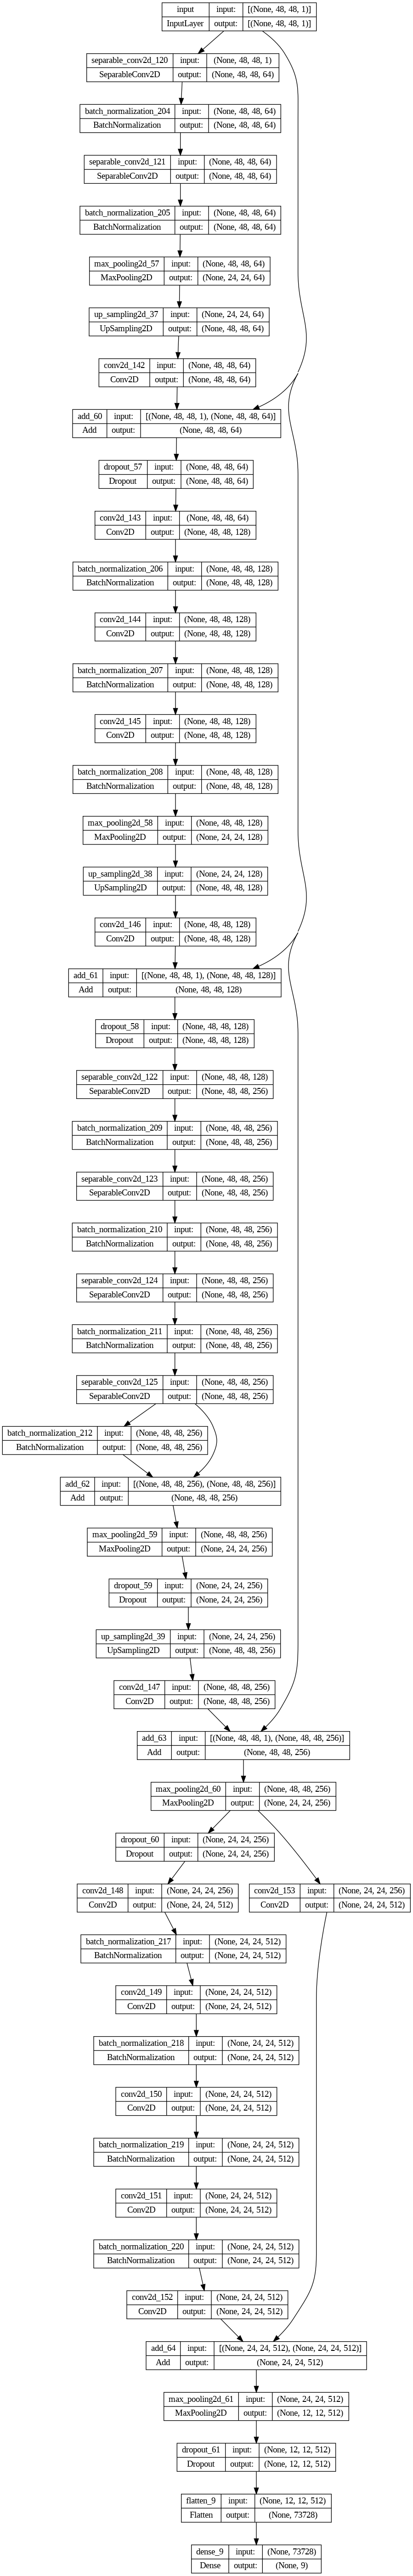

In [ ]:
# # Вариант 1 с использованием residual connection
# from keras.layers import Add, Conv2D
# import keras.regularizers as regularizers

# input_layer = keras.layers.Input(shape=image_size, name='input')
# # (1 блок) 2 слоя сепарабельных сверток (SeparableConv2D) по 64 фильтра с активацией ReLU и нормализацией батча
# conv1 = keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
# bn1 = keras.layers.BatchNormalization()(conv1)
# conv2 = keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', padding='same')(bn1)
# bn2 = keras.layers.BatchNormalization()(conv2)
# pool1 = keras.layers.MaxPooling2D(pool_size=(2,2))(bn2)

# # residual connection
# up1 = keras.layers.UpSampling2D()(pool1)
# conv_up1 = Conv2D(64, 2, activation='relu', padding='same')(up1)
# residual1 = Add()([input_layer, conv_up1])
# dropout1 = keras.layers.Dropout(0.3)(residual1)

# # (2 блок) 3 сверточных слоя (Conv2D) по 128 фильтров с активацией ReLU и нормализацией батча.
# conv3 = keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(dropout1)
# bn3 = keras.layers.BatchNormalization()(conv3)
# conv4 = keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(bn3)
# bn4 = keras.layers.BatchNormalization()(conv4)
# conv5 = keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(bn4)
# bn5 = keras.layers.BatchNormalization()(conv5)
# pool2 = keras.layers.MaxPooling2D(pool_size=(2,2))(bn5)

# # residual connection
# up2 = keras.layers.UpSampling2D()(pool2)
# conv_up2 = Conv2D(128, 2, activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(up2)
# residual2 = Add()([input_layer, conv_up2])
# dropout2 = keras.layers.Dropout(0.3)(residual2)

# # (3 блок) сепарабельные свертки по 256 фильтров с активацией ReLU и нормализацией батча
# conv6 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(dropout2)
# bn6 = keras.layers.BatchNormalization()(conv6)
# conv7 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(bn6)
# bn7 = keras.layers.BatchNormalization()(conv7)
# conv8 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(bn7)
# bn8 = keras.layers.BatchNormalization()(conv8)
# conv9 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(bn8)
# bn9 = keras.layers.BatchNormalization()(conv9)

# # residual connection
# residual3 = Add()([conv9, bn9])
# pool3 = keras.layers.MaxPooling2D(pool_size=(2,2))(residual3)
# dropout3 = keras.layers.Dropout(0.3)(pool3)

# # 4 блок (сепарабельные свертки по 256 фильтров с активацией ReLU и нормализацией батча)
# conv10 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(dropout3)
# bn10 = keras.layers.BatchNormalization()(conv10)
# conv11 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(bn10)
# bn11 = keras.layers.BatchNormalization()(conv11)
# conv12 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(bn11)
# bn12 = keras.layers.BatchNormalization()(conv12)
# conv13 = keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same')(bn12)
# bn13 = keras.layers.BatchNormalization()(conv13)

# # residual connection
# up3 = keras.layers.UpSampling2D()(dropout3)
# conv_up3 = Conv2D(256, 2, activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(up3)
# residual4 = Add()([input_layer, conv_up3])
# pool4 = keras.layers.MaxPooling2D(pool_size=(2,2))(residual4)
# dropout4 = keras.layers.Dropout(0.3)(pool4)

# # (5 блок) 2 полносвязных слоя (Dense) с 512 нейронами и активацией ReLU
# conv14 = keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(dropout4)
# bn14 = keras.layers.BatchNormalization()(conv14)
# conv15 = keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(bn14)
# bn15 = keras.layers.BatchNormalization()(conv15)
# conv16 = keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(bn15)
# bn16 = keras.layers.BatchNormalization()(conv16)
# conv17 = keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same')(bn16)
# bn17 = keras.layers.BatchNormalization()(conv17)

# # residual connection
# conv_up4 = Conv2D(512, 2, activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(bn17)
# conv_pool4 = Conv2D(512, 1, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool4)
# residual5 = Add()([conv_up4, conv_pool4])
# pool5 = keras.layers.MaxPooling2D(pool_size=(2,2))(residual5)
# dropout5 = keras.layers.Dropout(0.3)(pool5)

# flatten = keras.layers.Flatten()(dropout5)

# # Выходной слой с активацией softmax для классификации
# output = keras.layers.Dense(len(np.unique(y)), activation='softmax')(flatten)

# # Создание модели
# model = keras.models.Model(inputs=input_layer, outputs=output)

# # Компиляция модели
# # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import keras.regularizers as regularizers
# вариант 2 (Sequential)
model = keras.Sequential([keras.layers.Input(shape=image_size, name='input'), # Входной блок (Input layer) - принимает изображения размером image_size
                          # (1 блок) 2 слоя сепарабельных сверток (SeparableConv2D) по 64 фильтра с активацией ReLU и нормализацией батча
                          keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.SeparableConv2D(64, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(0.3),
                          # (2 блок) 3 сверточных слоя (Conv2D) по 128 фильтров с активацией ReLU и нормализацией батча.
                          keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          # комбинированная регуляризация последнего сверточного слоя
                          keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same',
                                              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
                          keras.layers.BatchNormalization(),
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(0.3),
                          # 3 блок (сепарабельные свертки по 256 фильтров с активацией ReLU и нормализацией батча)
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(0.3),
                          # 4 блок (сепарабельные свертки по 256 фильтров с активацией ReLU и нормализацией батча)
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.SeparableConv2D(256, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(0.3),
                          # 5 блок (4 сверточных слоя по 512 фильтров с активацией ReLU и нормализацией батча.)
                          keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'),
                          keras.layers.BatchNormalization(),
                          # комбинированная регуляризация последнего сверточного слоя
                          keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same',
                                              kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
                          keras.layers.BatchNormalization(),
                          keras.layers.MaxPooling2D(pool_size=(2,2)),
                          keras.layers.Dropout(0.3),
                          # Выходной блок (Output layer)
                          keras.layers.Flatten(), # слой Flatten и плотно соединенный слой (Dense layer) с softmax активацией
                          keras.layers.Dense(len(np.unique(y)), activation='softmax')])

model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_30 (Separ  (None, 48, 48, 64)        137       
 ableConv2D)                                                     
                                                                 
 batch_normalization_48 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 separable_conv2d_31 (Separ  (None, 48, 48, 64)        4736      
 ableConv2D)                                                     
                                                                 
 batch_normalization_49 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 24, 24, 64)       

In [ ]:
from keras.optimizers import Adam
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
# opt = SGD(learning_rate=0.0001, momentum=0.9)
# opt = RMSprop(learning_rate=0.0001, rho=0.9)

# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
score = model.evaluate(test_flow)
print('Test loss:', score[0], '\n', 'Test accuracy:', score[1])

150/150 [==============================] - 19s 77ms/step - loss: 2.4558 - accuracy: 0.1482
Test loss: 2.455779552459717 
 Test accuracy: 0.14824910461902618


In [ ]:
score = model.evaluate(test_flow)
print('Test loss:', score[0], '\n', 'Test accuracy:', score[1])

75/75 [==============================] - 12s 149ms/step - loss: 2.5998 - accuracy: 0.1482
Test loss: 2.599762201309204 
 Test accuracy: 0.14824910461902618


In [ ]:
# !pip install autokeras
# import autokeras as ak
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

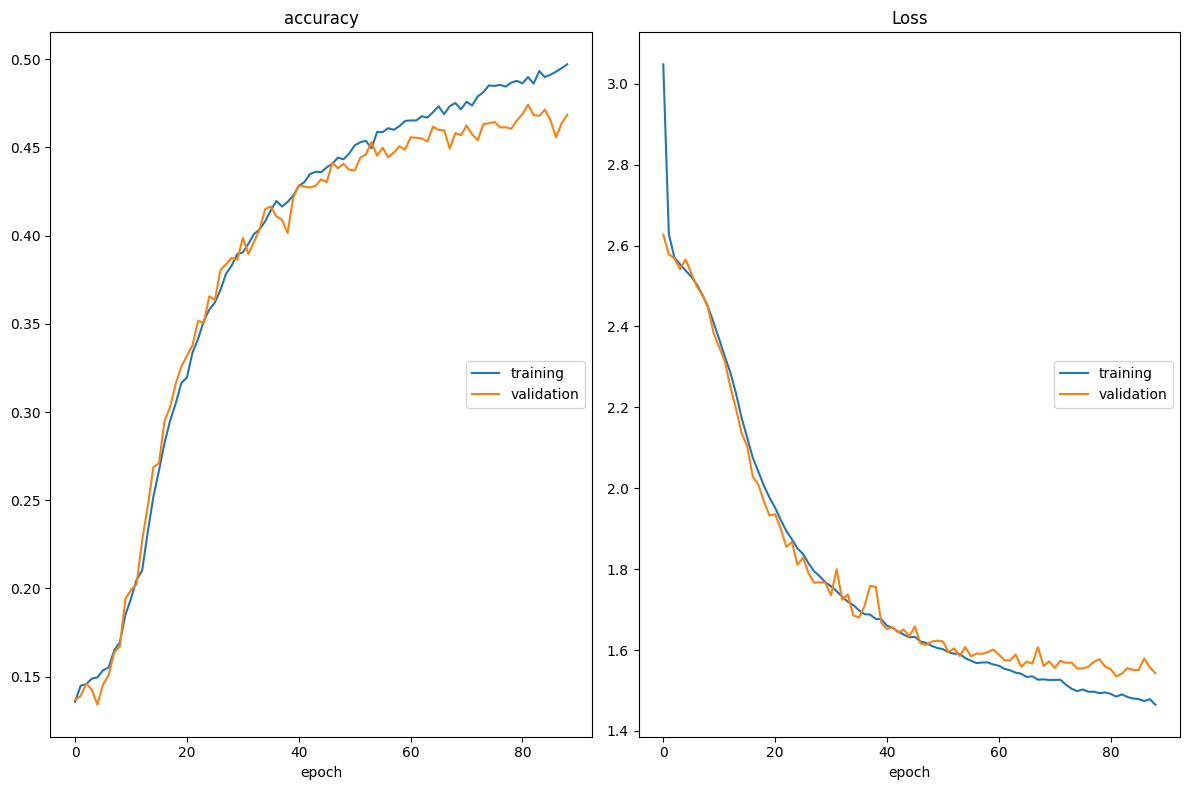

accuracy
	training         	 (min:    0.136, max:    0.497, cur:    0.497)
	validation       	 (min:    0.134, max:    0.474, cur:    0.469)
Loss
	training         	 (min:    1.465, max:    3.048, cur:    1.465)
	validation       	 (min:    1.534, max:    2.627, cur:    1.543)
Restoring model weights from the end of the best epoch: 82.

Epoch 89: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
521/521 [==============================] - 60s 114ms/step - loss: 1.4648 - accuracy: 0.4971 - val_loss: 1.5429 - val_accuracy: 0.4685 - lr: 1.0000e-04
Epoch 89: early stopping


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.0001,
                          patience=7,
                          verbose=1,
                          restore_best_weights=True,)

mcheckpoint = ModelCheckpoint("callback_model.h5",
                              save_best_only=True,
                              monitor='val_accuracy')

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                                 factor=0.5,
                                 patience=7,
                                 min_lr=1e-7,
                                 verbose=1,)

callbacks = [[PlotLossesCallback()],
             earlystop,
             mcheckpoint,
             lr_scheduler]

history = model.fit(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_flow,
                    callbacks = callbacks)

In [ ]:
# Save the TF model
model.save("/content/drive/MyDrive/skillbox-computer-vision-project/tf_model_48_Adam05_64")

In [ ]:
# score = model.evaluate(test_flow)
# print('Test loss:', score[0], '\n', 'Test accuracy:', score[1])

224/224 [==============================] - 12s 53ms/step - loss: 1.6959 - accuracy: 0.4276
Test loss: 1.69594144821167 
 Test accuracy: 0.4275529384613037


In [ ]:
# # batch_size=128, regularizers.l1_l2(последнии слои)
# score = model.evaluate(test_flow)
# print('Test loss:', score[0], '\n', 'Test accuracy:', score[1])

75/75 [==============================] - 10s 133ms/step - loss: 1.5804 - accuracy: 0.4528
Test loss: 1.5804195404052734 
 Test accuracy: 0.4528203010559082


In [ ]:
# # batch_size=64, regularizers.l1_l2(последнии слои)
# score = model.evaluate(test_flow)
# print('Test loss:', score[0], '\n', 'Test accuracy:', score[1])

150/150 [==============================] - 8s 50ms/step - loss: 1.5503 - accuracy: 0.4769
Test loss: 1.5503334999084473 
 Test accuracy: 0.47693437337875366


In [ ]:
# # batch_size=64 regularizers.l1_l2(custom)
score = model.evaluate(test_flow)
print('Test loss:', score[0], '\n', 'Test accuracy:', score[1])

224/224 [==============================] - 15s 68ms/step - loss: 1.5426 - accuracy: 0.4656
Test loss: 1.5426452159881592 
 Test accuracy: 0.46557629108428955


In [ ]:

model_path = '/content/drive/MyDrive/skillbox-computer-vision-project/callback_model_adam_05.h5'
fer_model = load_model(model_path)

score = fer_model.evaluate(test_flow)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

224/224 [==============================] - 23s 98ms/step - loss: 1.5367 - accuracy: 0.4740
Test loss: 1.5367257595062256
Test accuracy: 0.47396379709243774


In [ ]:
fer_model.save("/content/drive/MyDrive/skillbox-computer-vision-project/tf_model_48_Adam06_64")

### Подготовка тестового датасета

In [ ]:
# скачиваем тестовыйй датасет
!gdown --id 12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=12QrDrLT1F-X7UycvOoApXFqxTw3Zx93K
To: /content/test_kaggle.zip
100% 222M/222M [00:13<00:00, 16.9MB/s]


In [ ]:
# Указываем путь к архиву
zip_path = '/content/test_kaggle.zip'
extract_path = '/content/drive/MyDrive/skillbox-computer-vision-project'

extract_and_display_images(zip_path, extract_path)

Разархивация: 100%|██████████| 5001/5001 [00:27<00:00, 181.09it/s]

Архив успешно разархивирован.


In [ ]:
k_source_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/test_kaggle/'
k_modified_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/modified_test/'

# Получаем список всех файлов изображений в исходной папке
image_files = [file for file in os.listdir(k_source_folder) if file.endswith('.jpg')]

if not os.path.exists(k_modified_folder):
    os.makedirs(k_modified_folder)

# Обрабатываем каждое изображение
for file in tqdm(image_files):
    # Открываем изображение
    image_path = os.path.join(k_source_folder, file)
    image = cv2.imread(image_path)

    # Изменяем размер изображения на (48, 48)
    resized_image = cv2.resize(image,(48, 48))

    # Конвертируем изображение в оттенки серого
    grayscaled_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Сохраняем обработанное изображение в папку modified_test
    modified_image_path = os.path.join(k_modified_folder, file)
    cv2.imwrite(modified_image_path, grayscaled_image)

# Выводим сообщение о завершении обработки
print("Все изображения обработаны и сохранены в папке modified_test.")

100%|██████████| 5000/5000 [01:11<00:00, 69.97it/s]

Все изображения обработаны и сохранены в папке modified_test.


### Проверка качества модели на тестовом датасете, создание csv файла для отправки kaggle

In [ ]:
k_modified_folder = '/content/drive/MyDrive/skillbox-computer-vision-project/modified_test/'

# Получаем список всех файлов изображений в исходной папке
image_files = [file for file in os.listdir(k_modified_folder) if file.endswith('.jpg')]

In [ ]:
# Создаем датасет с указанными столбцами
test_set = pd.DataFrame({'image_path': image_files, 'emotion': ''})
test_set['image_path'] = test_set['image_path'].apply(lambda x: ('/content/drive/MyDrive/skillbox-computer-vision-project/modified_test/' + str(x)))
test_set.head()

,image_path,emotion
0,/content/drive/MyDrive/skillbox-computer-visio...,
1,/content/drive/MyDrive/skillbox-computer-visio...,
2,/content/drive/MyDrive/skillbox-computer-visio...,
3,/content/drive/MyDrive/skillbox-computer-visio...,
4,/content/drive/MyDrive/skillbox-computer-visio...,


In [ ]:
images = test_set['image_path'].apply(imread)   # Use imread to extract the pixel information of the images
images_test = np.array(images.to_list())   # Save the pixel information into a list name images_test
images_test = images_test/255.0            # Scale the images

In [ ]:
images[15]

array([[70, 68, 66, ..., 71, 67, 72],
       [76, 70, 69, ..., 76, 66, 76],
       [77, 72, 75, ..., 83, 69, 85],
       ...,
       [12,  9, 25, ..., 24, 16, 62],
       [ 9,  8, 17, ..., 16, 23, 45],
       [15,  8, 17, ..., 14,  5, 21]], dtype=uint8)

In [ ]:
file_path = "/content/drive/MyDrive/skillbox-computer-vision-project/tf_model_48_Adam06_64"
fer_model = load_model(model_path)

In [ ]:
prediction = fer_model.predict(images_test)
prediction = np.argmax(prediction,axis=1)

157/157 [==============================] - 3s 12ms/step


In [ ]:
test_set['emotion'] = prediction

In [ ]:
label_encoded_map= {0:'anger',
                    1:'contempt',
                    2:'disgust',
                    3:'fear',
                    4:'happy',
                    5:'neutral',
                    6:'sad',
                    7:'surprise',
                    8:'uncertain'}
test_set.emotion = test_set.emotion.map(label_encoded_map)
test_set['image_path'] = test_set['image_path'].str.replace('/content/drive/MyDrive/skillbox-computer-vision-project/modified_test/', '')
test_set.head()

,image_path,emotion
0,4599.jpg,fear
1,46.jpg,sad
2,460.jpg,sad
3,4600.jpg,anger
4,4601.jpg,fear


In [ ]:
test_set.to_csv('/content/drive/MyDrive/skillbox-computer-vision-project/predictions.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/skillbox-computer-vision-project/predictions.csv')
df.head()

,image_path,emotion
0,4599.jpg,fear
1,46.jpg,sad
2,460.jpg,sad
3,4600.jpg,anger
4,4601.jpg,fear
